# Sales: Time Series Forecasting

This dataset contains the revenue (sales) of a company from april 2022 to march 2023, the goals to achive are the following:

- Compute margin, margin percent
- Create a simple 10 bin segmentation.
- Compute mean sales per month and show his behavior
- Calculate de mean sales growth per month
- Import additional information to support forecast
- Apply a regression model to forecast sales until january 2025
- Calculate de growth per year on each month after forecasting

# Contents

- [1. Loading dataset](#1)
- [2. Data Wrangling](#2)
- [3. Mean Sales Per Month](#3)
- [3.1 Total sales per month](#3.1)
- [4. Sales Forecasting](#4)
- [4.1 Outlier Detection](#4.1)
- [4.2 Aditional Resources](#4.2)
- [4.3 Feature engineering](#4.3)
- [5. Lasso Regression](#5)
- [5.1 Pipeline](#5.1)
- [5.2 Regression Model](#5.2)
- [6. Annual Growth](#6)

<a name = '1'></a>
# 1. Loading Dataset

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Time Series decomposition / Analysis 
from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import ccf

# Feature engineering / Pipelines
from sktime.transformations.series.time_since import TimeSince
from sklearn.preprocessing import PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures
from feature_engine.selection.drop_features import DropFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline, make_union, make_pipeline
from sklearn.base import clone

# Regresion Model / Metrics
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error as mse

# Notebook Settings
from sklearn import set_config
set_config(transform_output = 'pandas')

plt.style.use('seaborn-v0_8-dark-palette')

In [2]:
file = 'Base Prueba.xlsx'

df = pd.read_excel(file)

df.head()

,identificador cliente,nombre cliente,Date,Cost USD,Financing Costs,Anticipation cost,Validation Costs,Rev Tax cost,Transfer cost,Transfer Tax,Withholdings assumed,Total Costs,Sales,Commisions,Margin,% GM,segmento
0,510555613,AAAABBB-1,2022-05-01,35594973,80542247,29805489,13867748,76910407,76742389,60066307,29994434,403523994,1053277668,2.106555e+07,NaN,NaN,NaN
1,510555613,AAAABBB-1,2022-06-01,49072039,9524087,4879928,58733743,93361384,67623535,75565117,50146193,408906026,1040746627,9.366720e+07,NaN,NaN,NaN
2,510555613,AAAABBB-1,2022-09-01,65343219,20324356,6717897,35951576,78200708,38362249,49097368,74492023,368489396,1635927799,1.308742e+08,NaN,NaN,NaN
3,510555613,AAAABBB-1,2022-11-01,6366652,69485745,62750641,15412979,56897582,93168936,64694357,4606653,373383545,1171163337,4.684653e+07,NaN,NaN,NaN
4,510555617,AAAABBB-2,2022-04-01,87555273,15368780,27122598,50924743,20665118,91794016,8060557,6238557,307729642,738419593,4.430518e+07,NaN,NaN,NaN


<a name = '2'></a>
# 2. Data Wrangling

- Checking dataset atributes
- Looking for duplicated values
- Looking for NaN values
- Cleaning column names
- Calculating margin, gross margin percent
- Making a basic segmentation from sales

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183803 entries, 0 to 183802
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   identificador cliente  183803 non-null  int64         
 1   nombre cliente         183803 non-null  object        
 2   Date                   183803 non-null  datetime64[ns]
 3   Cost USD               183803 non-null  int64         
 4   Financing Costs        183803 non-null  int64         
 5   Anticipation cost      183803 non-null  int64         
 6   Validation Costs       183803 non-null  int64         
 7   Rev Tax cost           183803 non-null  int64         
 8   Transfer cost          183803 non-null  int64         
 9   Transfer Tax           183803 non-null  int64         
 10  Withholdings assumed   183803 non-null  int64         
 11  Total Costs            183803 non-null  int64         
 12  Sales                  183803 non-null  int6

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
identificador cliente,183803.0,5.109102e+08,1.600276e+05,5.105556e+08,5.107734e+08,5.109483e+08,5.110486e+08,5.111439e+08
Cost USD,183803.0,4.936527e+07,2.846645e+07,2.597300e+04,2.476382e+07,4.935486e+07,7.402520e+07,9.865259e+07
Financing Costs,183803.0,4.950506e+07,2.846028e+07,2.503100e+04,2.484634e+07,4.961270e+07,7.406883e+07,9.865217e+07
Anticipation cost,183803.0,4.947975e+07,2.849006e+07,2.502300e+04,2.485265e+07,4.952504e+07,7.421519e+07,9.865229e+07
Validation Costs,183803.0,4.936202e+07,2.844690e+07,2.532600e+04,2.467690e+07,4.933190e+07,7.394894e+07,9.865250e+07
Rev Tax cost,183803.0,4.931145e+07,2.848775e+07,2.514200e+04,2.462191e+07,4.928410e+07,7.396835e+07,9.865176e+07
Transfer cost,183803.0,4.934814e+07,2.844055e+07,2.584400e+04,2.479029e+07,4.931492e+07,7.398690e+07,9.865247e+07
Transfer Tax,183803.0,4.950033e+07,2.846959e+07,2.526900e+04,2.481007e+07,4.955862e+07,7.409528e+07,9.865080e+07
Withholdings assumed,183803.0,4.938119e+07,2.840532e+07,2.536500e+04,2.480606e+07,4.942813e+07,7.397940e+07,9.865261e+07
Total Costs,183803.0,3.952532e+08,8.038340e+07,8.430907e+07,3.398982e+08,3.953530e+08,4.503682e+08,7.139351e+08


In [5]:
print(f'Duplicated rows: \n{df.duplicated().sum()}\n')
print(f'Nan Values: \n{df.isnull().sum()}')

Duplicated rows: 
0

Nan Values: 
identificador cliente         0
nombre cliente                0
Date                          0
Cost USD                      0
Financing Costs               0
Anticipation cost             0
Validation Costs              0
Rev Tax cost                  0
Transfer cost                 0
Transfer Tax                  0
Withholdings assumed          0
Total Costs                   0
Sales                         0
Commisions                    0
Margin                   183803
% GM                     183803
segmento                 183803
dtype: int64


In [6]:
# Clean dataframe, create segmentation and calculate margin - margin %
def tweak_df(df):
    return (
        df
        # Adjust column names
        .rename(columns = lambda col: col.replace(' ', '_').lower())
        .assign(
            # Margin and growth margin percent
            margin = df['Sales'] - df['Total Costs'] - df['Commisions'],
            gm_perc = (df['Sales'] - df['Total Costs'] - df['Commisions']) / df['Sales'],
            # Basic 10 bin segmentation
            segmento = pd.cut(df['Sales'], 10),
        )
        # Dropping unnecesary columns
        .drop(columns = ['%_gm'])
        .sort_values('date')
    )

df_ = tweak_df(df)
df_.head()

,identificador_cliente,nombre_cliente,date,cost_usd,financing_costs,anticipation_cost,validation_costs,rev_tax_cost,transfer_cost,transfer_tax,withholdings_assumed,total_costs,sales,commisions,margin,segmento,gm_perc
51561,510801543,AAAABBB-6130,2022-04-01,22521351,63546527,26308069,2155020,70414266,77734603,25435724,66326273,354441833,1483599349,1.038520e+08,1.025306e+09,"(1423991536.2, 1615986782.8]",0.691093
59161,510828530,AAAABBB-7099,2022-04-01,18610964,35070911,48325140,24509449,12993998,71364597,85700253,50212195,346787507,1395125559,1.534638e+08,8.948742e+08,"(1231996289.6, 1423991536.2]",0.641429
16371,510658495,AAAABBB-1888,2022-04-01,22511139,4067128,18561356,3253558,52858270,81799857,56912430,29503261,269466999,700589979,6.305310e+07,3.680699e+08,"(656010549.8, 848005796.4]",0.525371
134602,511044146,AAAABBB-17209,2022-04-01,6738102,93576502,63738130,63300737,20495120,56142395,59655054,56472511,420118551,1301615964,6.508080e+07,8.164166e+08,"(1231996289.6, 1423991536.2]",0.627233
165390,511108965,AAAABBB-21988,2022-04-01,70922663,81671711,55260332,63018613,22708919,33523821,53954199,50638859,431699117,1225627706,1.348190e+08,6.591095e+08,"(1040001043.0, 1231996289.6]",0.537773


<a name = '3'></a>
# 3. Mean Sales Per Month
Compute:
- Average sales per month
- Clients with sales greater or equal than the average sales per month
- Growth month by month (quantity and percentage)

In [7]:
# Compute mean sales per month and clients who made sells above it 
def avg_df(df):
    
    df2 = (df
        .assign(
            # Mark clients with sales greater or equal than mean month sales
            above_avg_sales = np.where(df.sales >= df_.groupby('date')['sales'].transform('mean'), True, False).astype('bool'),
        )
        .groupby('date')
        .agg({'sales' : 'mean', 'identificador_cliente' : 'count', 'above_avg_sales' : 'sum'})
    )
    
    return(
        df2
        .assign(
            clients_abv_mean = df2.above_avg_sales / df2.identificador_cliente,
            # Compute growth per month (Qty - Perc)
            growth_qty = df2.sales - df2.sales.shift(1).bfill(),
            growth_perc = (df2.sales - df2.sales.shift(1).bfill()) / df2.sales * 100,
        )
        .rename(columns = {'sales' : 'mean_sales', 'identificador_cliente' : 'total_sales_count'})
    )
        

avg_sales = avg_df(df_)
avg_sales

,mean_sales,total_sales_count,above_avg_sales,clients_abv_mean,growth_qty,growth_perc
date,,,,,,
2022-04-01,1.034355e+09,16190,8113,0.501112,0.000000e+00,0.000000
2022-05-01,1.042973e+09,16364,8175,0.499572,8.617904e+06,0.826283
2022-06-01,1.039630e+09,16241,8133,0.500770,-3.342647e+06,-0.321523
2022-07-01,1.044971e+09,15947,8006,0.502038,5.341397e+06,0.511152
2022-08-01,1.043180e+09,16044,8035,0.500810,-1.791097e+06,-0.171696
2022-09-01,1.052538e+09,15665,7883,0.503224,9.357861e+06,0.889076
2022-10-01,1.044756e+09,15151,7573,0.499835,-7.781726e+06,-0.744836
2022-11-01,1.036179e+09,15131,7509,0.496266,-8.577603e+06,-0.827811
2022-12-01,1.047175e+09,14770,7386,0.500068,1.099653e+07,1.050114


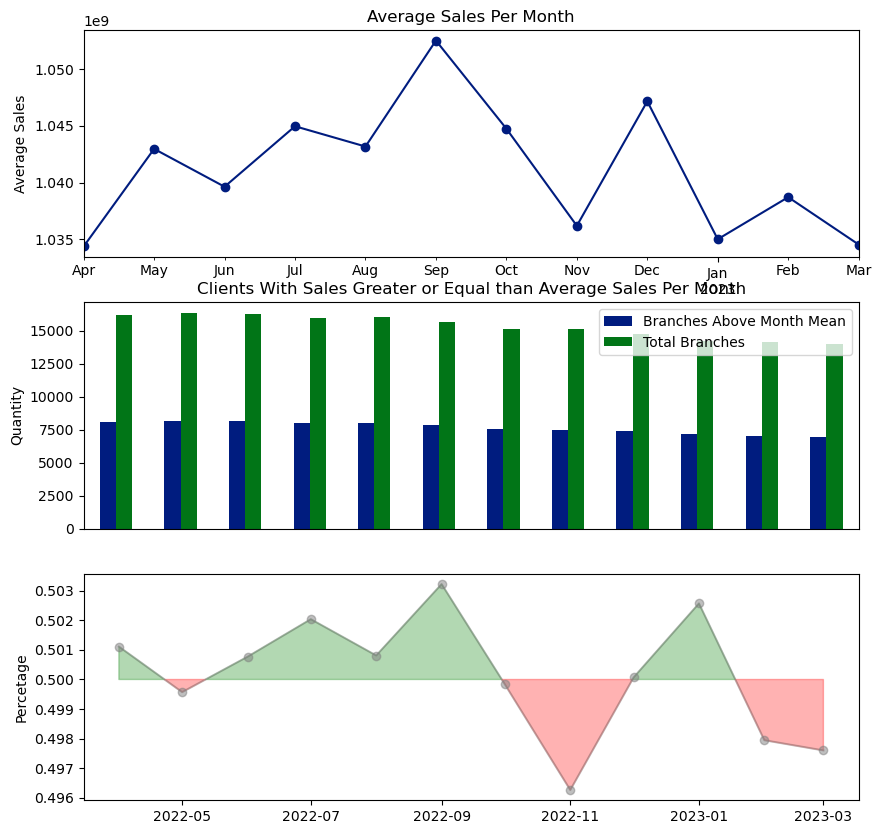

In [8]:
# Plotting mean sales behavior
fig, ax = plt.subplots(nrows = 3, figsize = (10, 10))

# Plots
avg_sales.plot(y = 'mean_sales', marker = 'o', legend = False, ax = ax[0])
avg_sales.plot(kind = 'bar', y = ['above_avg_sales', 'total_sales_count'], ax = ax[1], xticks = [], )

ax[2].plot(avg_sales.index, avg_sales.clients_abv_mean, marker = 'o', color = 'gray', alpha = 0.5)
ax[2].fill_between(avg_sales.index, 0.5, avg_sales.clients_abv_mean, where = avg_sales.clients_abv_mean > 0.5, color = 'g', alpha = 0.3, interpolate = True)
ax[2].fill_between(avg_sales.index, 0.5, avg_sales.clients_abv_mean, where = avg_sales.clients_abv_mean < 0.5, color = 'r', alpha = 0.3, interpolate = True)

# Plot settings
ax[0].set_xlabel('')
ax[0].set_ylabel('Average Sales')
ax[0].set_title('Average Sales Per Month')

ax[1].set_xlabel('')
ax[1].set_ylabel('Quantity')
ax[1].set_title('Clients With Sales Greater or Equal than Average Sales Per Month')
ax[1].legend(['Branches Above Month Mean', 'Total Branches'])

ax[2].set_ylabel('Percetage')

plt.show()

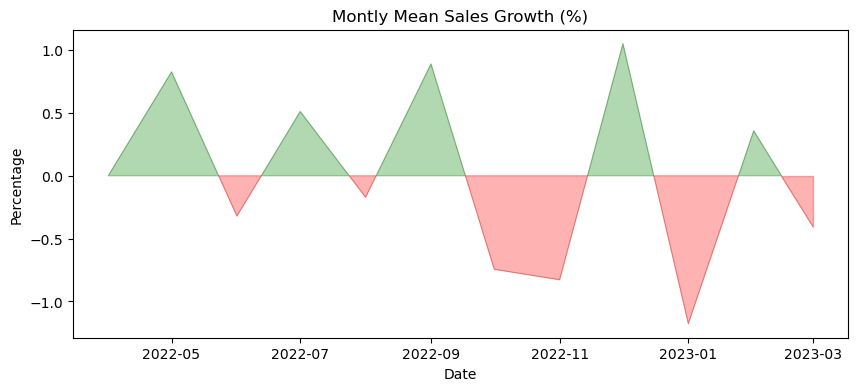

In [9]:
# Plotting mean sales percent
plt.figure(figsize = (10, 4))

# Plot / Fill
plt.plot(avg_sales.index, avg_sales.growth_perc, color = 'black', alpha = 0.3, lw = 0.3)

plt.fill_between(avg_sales.index, 0, avg_sales.growth_perc, 
                 where = avg_sales.growth_perc > 0, color = 'green', alpha = 0.3
                 , interpolate = True)
plt.fill_between(avg_sales.index, 0, avg_sales.growth_perc, 
                 where = avg_sales.growth_perc < 0, color = 'red', alpha = 0.3
                 , interpolate = True)

# Settings
plt.title('Montly Mean Sales Growth (%)')
plt.xlabel('Date')
plt.ylabel('Percentage')

plt.show()

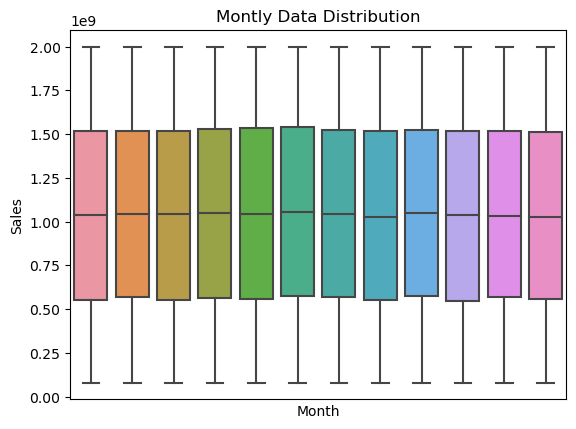

In [10]:
# Montly data distribution - looking for outliers on each month
sns.boxplot(df_, x = 'date', y = 'sales')

plt.xticks([])
plt.xlabel('Month')
plt.ylabel('Sales')

plt.title('Montly Data Distribution')

plt.show()

<a name = '3.1'><a/>
## 3.1 Total sales per month

- Compute - Plot total sales per month.
- You'll see seasonality in each queater, this will be corroborated in the second plot, where you'll find there is a peak moment on the 2nd month on each quarter.
- For this reason i'll apply STL algorithm, it will provide the trend, seasonal and residual components of the series.

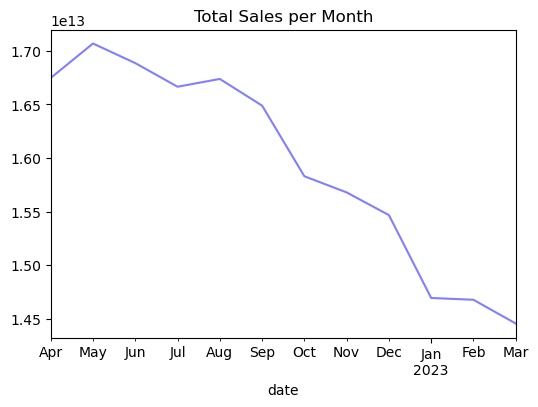

In [11]:
# Total sales per month, this data will be used to develop the forecasting model
total_sales = (
    df_
    .groupby('date')['sales']
    .sum()
    .to_frame()
)

# Plot
total_sales.plot(legend = False, color = 'b', alpha = 0.5, figsize = (6, 4))
plt.title('Total Sales per Month')

plt.show()

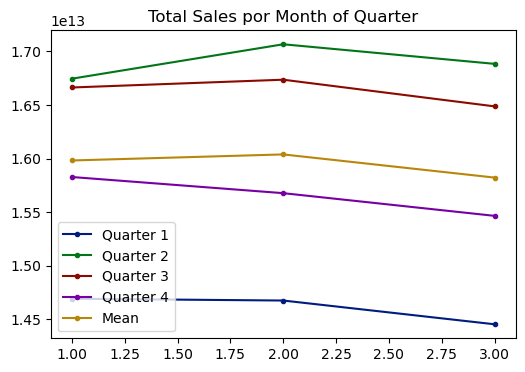

In [12]:
# Explore month behavior in each quarter
fig, ax = plt.subplots(figsize = (6, 4))

def sales_per_month_of_q(df):
    
    df_1 = df.copy()
    df_1['quarter_'] = total_sales.index.quarter
    temp = pd.DataFrame(index = np.arange(1, 4))

    for q in np.arange(1, 5):

        temp[f'sales_{q}'] = df.loc[df_1.quarter_ == q].sales.to_list()

    temp['mean_month_of_quarter'] = temp.mean(axis = 1)
    
    return temp


temp = sales_per_month_of_q(total_sales)

temp.plot(ax = ax, marker = '.', legend = True)

plt.legend(['Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4', 'Mean'])
plt.title('Total Sales por Month of Quarter')

plt.show()

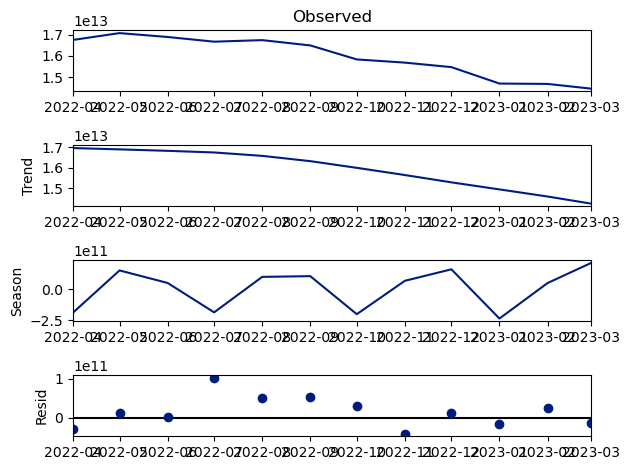

In [13]:
# Time series decomposition
res = STL(total_sales, period = 3).fit()
res.plot();

<a name = '4'><a/>
# 4. Sales Forecasting
- Outlier detection
- Aditional Resources
- Feature engineering

<a name = '4.1'><a/>
## 4.1 Outlier Detection

In [14]:
# Function: temporal dataframe to detect outliers
def outlier_df(df, alpha = 1.5):
    ts_temp = df.copy()
    
    # Setting IRQ
    Q3 = res.resid.quantile(0.75)
    Q1 = res.resid.quantile(0.25)
    IQR = Q3 - Q1
    
    # Adding upper and lower thresholds
    ts_temp['upper'] = Q3 + alpha * IQR
    ts_temp['lower'] = Q1 - alpha * IQR
    
    return(
        ts_temp
        .assign(
            # Adding residuals and seasonal + trend columns from the time series decomoposition
            residuals = res.resid,
            seasonal_trend = res.seasonal + res.trend,
            is_outlier = ((res.resid < ts_temp.lower) | (res.resid > ts_temp.upper))
        )
    )


ts_temp = outlier_df(total_sales)
ts_temp

,sales,upper,lower,residuals,seasonal_trend,is_outlier
date,,,,,,
2022-04-01,16746203696564,1.112358e+11,-8.885063e+10,-2.930797e+10,1.677551e+13,False
2022-05-01,17067204812923,1.112358e+11,-8.885063e+10,1.153810e+10,1.705567e+13,False
2022-06-01,16884631245810,1.112358e+11,-8.885063e+10,1.966609e+09,1.688266e+13,False
2022-07-01,16664159268504,1.112358e+11,-8.885063e+10,1.015530e+11,1.656261e+13,False
2022-08-01,16736785138320,1.112358e+11,-8.885063e+10,5.030173e+10,1.668648e+13,False
2022-09-01,16488010680770,1.112358e+11,-8.885063e+10,5.420405e+10,1.643381e+13,False
2022-10-01,15829105124719,1.112358e+11,-8.885063e+10,3.150392e+10,1.579760e+13,False
2022-11-01,15678422290057,1.112358e+11,-8.885063e+10,-3.962149e+10,1.571804e+13,False
2022-12-01,15466780514439,1.112358e+11,-8.885063e+10,1.188773e+10,1.545489e+13,False


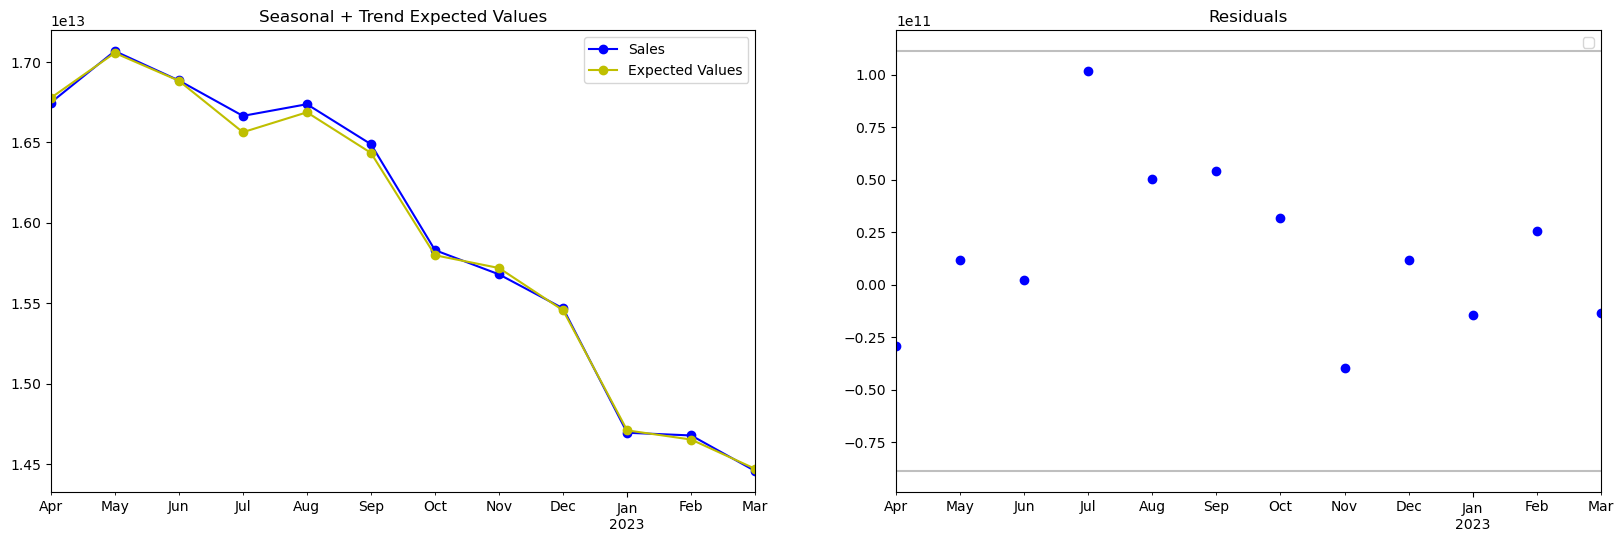

In [15]:
# Plotting outliers (time series - residuals)
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))

ts_temp.plot(y = 'sales', marker = 'o', color = 'b', ax = ax[0])
ts_temp.plot(y = 'seasonal_trend', marker = 'o', color = 'y', ax = ax[0])

ts_temp.plot(y = 'residuals', marker = 'o', linestyle = '', color = 'b', ax = ax[1])
ts_temp.plot(y = ['upper', 'lower'], color = 'gray', alpha = 0.5, ax = ax[1])

# Highligh outliers
if ts_temp.is_outlier.any():
    ts_temp.loc[ts_temp.is_outlier].plot(y = 'sales', marker = 'o', linestyle = '', color = 'r', alpha = 0.8, ax = ax[0])
    ts_temp.loc[ts_temp.is_outlier].plot(y = 'residuals', marker = 'o', linestyle = '', color = 'r', alpha = 0.8, ax = ax[1])

# Plot settings
ax[0].legend(['Sales', 'Expected Values', 'Outlier'])
ax[0].set_title('Seasonal + Trend Expected Values')
ax[0].set_xlabel('')

ax[1].legend([])
ax[1].set_title('Residuals')
ax[1].set_xlabel('')

plt.show()

<a name = '4.2'><a/>
## 4.2 Aditional Resources
For this project the following additional information will be taken into account:
- Inflation (IPC-Colombia)
- TIP - Bank Intervention Fee (Colombia)
- Market's Representative Exchange-Rate - Colombian Peso vs. USD

They influence the consummer behavior and affect future company revenues, thus they could help the model to forecast the sales in the up coming months more accurately.

**There are outliers on the inflation and TIP series, they will be imputed using linear interpolation.**

### 4.2.1 Inflation

In [16]:
# Loading inflation dataset
inf = pd.read_csv('1_inflacion.csv', delimiter = ';')

# Function: to clean dataframe
def tweak_inf(df):
    df = df.head(20).copy()

    # Format days - string data type
    dates = [f'{str(x)[:4]}-{str(x)[4:]}-01' for x in df['Año(aaaa)-Mes(mm)']]

    return (
        df
        .assign(
            # Adding dates with datetime format
            date = pd.to_datetime(dates),
        )
        # Drop, rename columns
        .drop(columns = ['Límite inferior', 'Meta de inflación', 'Límite superior', 'Año(aaaa)-Mes(mm)'])
        .rename(columns = {'Inflación total 1' : 'inflacion'})
        # Index change and filter
        .set_index('date')
        .loc[ts_temp.index]
    )


inf = tweak_inf(inf)
inf

,inflacion
date,
2022-04-01,9.23
2022-05-01,9.07
2022-06-01,9.67
2022-07-01,10.21
2022-08-01,10.84
2022-09-01,11.44
2022-10-01,12.22
2022-11-01,12.53
2022-12-01,13.12


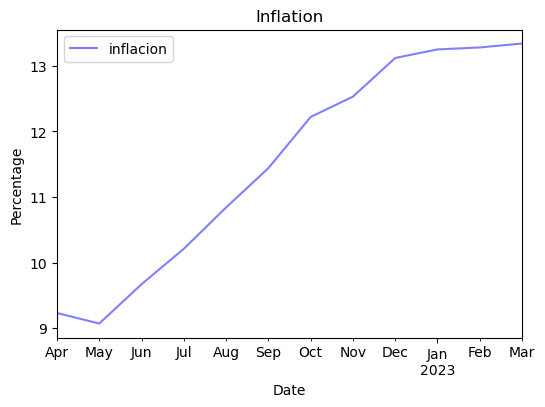

In [17]:
# Inflation time series plot
inf.plot(color = 'b', alpha = 0.5, figsize = (6, 4))

plt.title('Inflation')
plt.ylabel('Percentage')
plt.xlabel('Date')

plt.show()

In [18]:
# Trend component
x = np.arange(0, len(inf))
inf_lws = lowess(inf.inflacion, x, frac = 0.5, it = 3)

# Adding trend data to inflation dataframe
def df_trend(df, df_1, column):
    
    # Trend column
    df['trend'] = df_1[:, 1]
    
    return(
        df
        .assign(
        # Adding Residuals to dataframe
        resid = column - df.trend
        )
    )


inf = df_trend(inf, inf_lws, inf.inflacion)

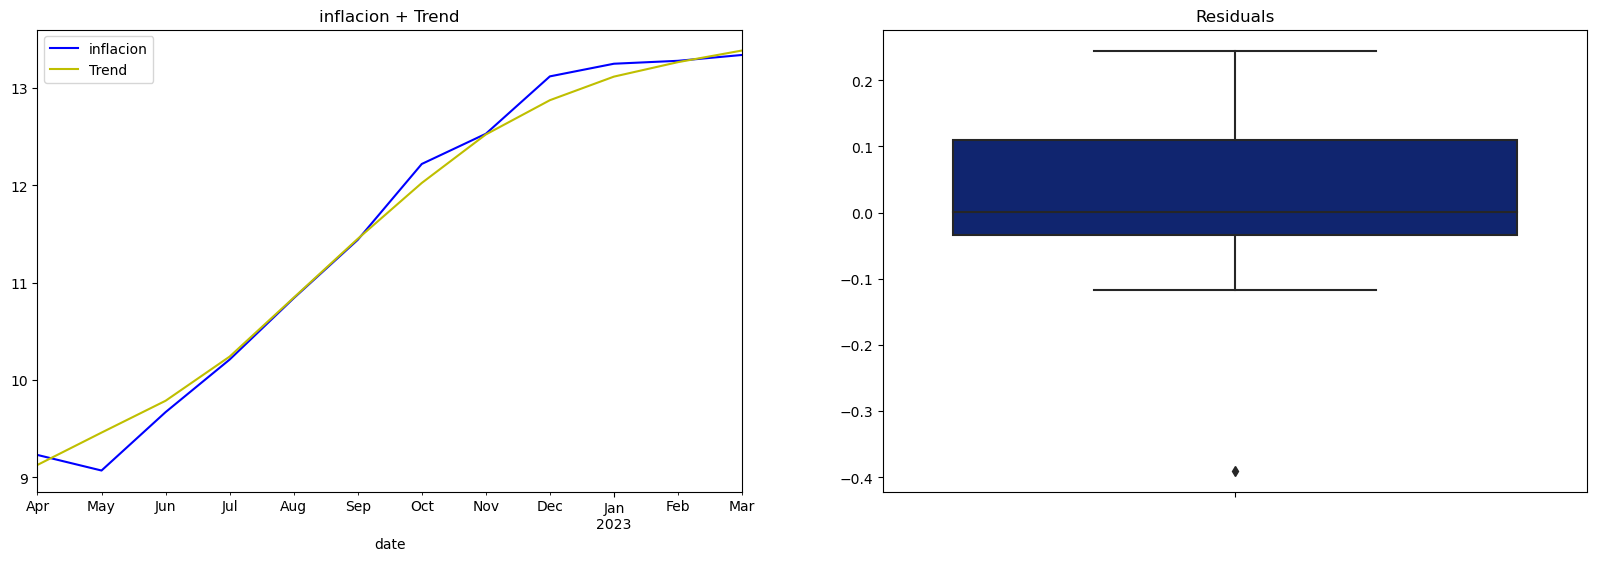

In [19]:
def plot_df(df, feature):
    
    # Plot parameters
    fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))
    
    # Time series + trend plot
    df.plot(y = feature, ax = ax[0], color = 'b')
    df.plot(y = 'trend', ax = ax[0], color = 'y')
    
    ax[0].set_title(f'{feature} + Trend')
    ax[0].legend([feature, 'Trend'])
    
    # Residuals Boxplot
    sns.boxplot(df, y = 'resid', ax = ax[1])
    
    ax[1].set_ylabel('')
    ax[1].set_title('Residuals')

    return plt.show()


plot_df(inf, 'inflacion')

In [20]:
# Add and highlight outliers
def outliers(df, alpha = 1.5):
    
    # Compute IQR
    Q3 = df.resid.quantile(0.75)
    Q1 = df.resid.quantile(0.25)
    IQR = Q3 - Q1
    
    # Adding upper and lower thresholds
    df['upper'] = Q3 + alpha * IQR
    df['lower'] = Q1 - alpha * IQR
    
    return(
        df
        .assign(
        # Highligth outliers (boolean array)
        is_outlier = ((df.resid > df.upper) | (df.resid < df.lower))
        )
    )


inf = outliers(inf)

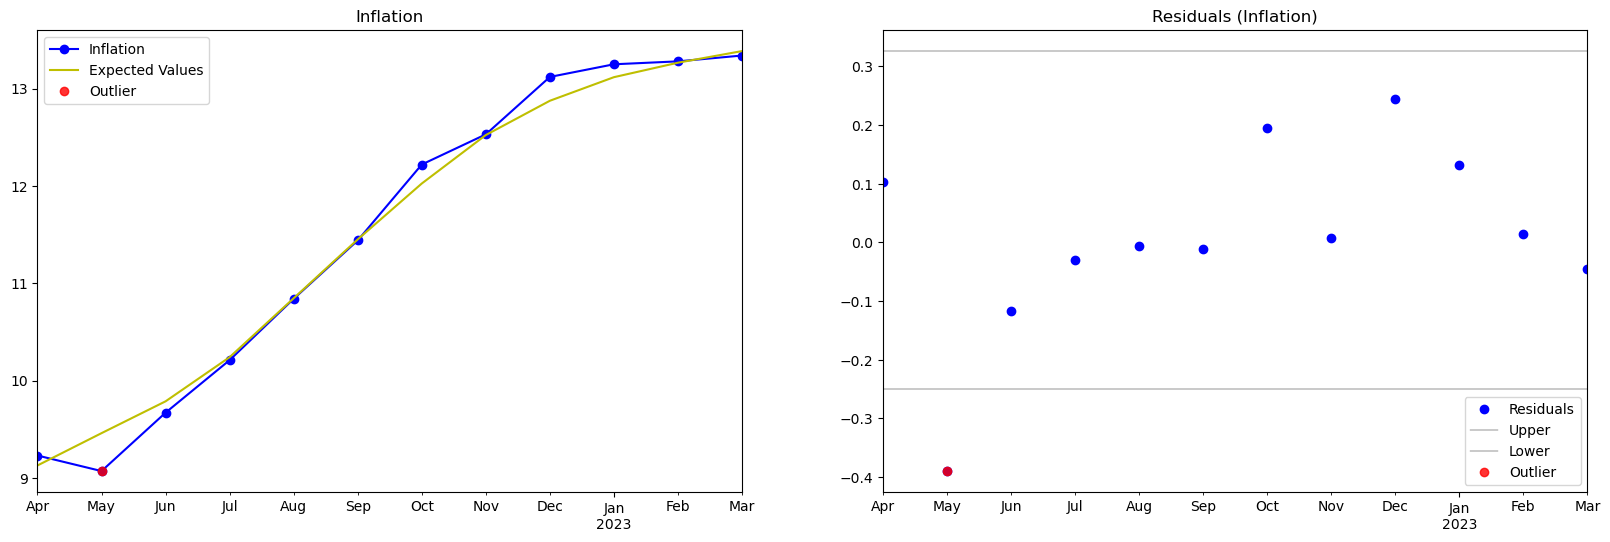

In [21]:
# Outliers plot
def plot_outliers(df, target):
    
    fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))

    # Inflation time series plot
    df.plot(y = target, marker = 'o', color = 'b', ax = ax[0])
    df.plot(y = 'trend', color = 'y', lw = 1.5, ax = ax[0])

    # Residuals plot
    df.plot(y = 'resid', marker = 'o', linestyle = '', color = 'b', ax = ax[1])
    df.plot(y = ['upper', 'lower'], color = 'black', lw = 0.3, ax = ax[1])

    # Highlighting outliers
    if df.is_outlier.any():
        df.loc[df.is_outlier].plot(y = 'resid', marker = 'o', linestyle = '', color = 'r', alpha = 0.8, ax = ax[1])
        df.loc[df.is_outlier].plot(y = target, marker = 'o', linestyle = '', color = 'r', alpha = 0.8, ax = ax[0])

    # Plot settings
    ax[0].legend(['Inflation', 'Expected Values', 'Outlier'])
    ax[0].set_title('Inflation')
    ax[0].set_xlabel('')

    ax[1].legend(['Residuals', 'Upper', 'Lower', 'Outlier'])
    ax[1].set_title('Residuals (Inflation)')
    ax[1].set_xlabel('')

    return plt.show()


plot_outliers(inf, 'inflacion')

In [22]:
# Remove outliers
inf.loc[inf.is_outlier, 'inflacion'] = np.nan

# Replacing values thru linear interpolation
inf['inflacion'] = inf.inflacion.interpolate(method = 'linear')

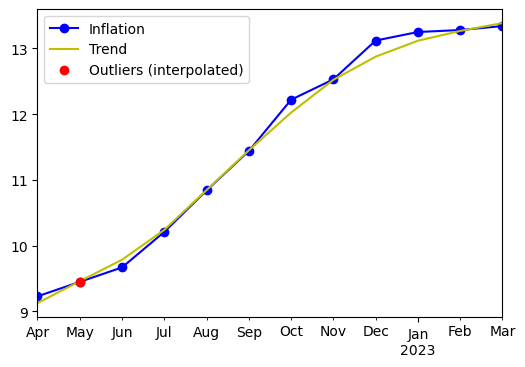

In [23]:
fig, ax = plt.subplots(figsize = (6, 4))

inf.plot(y = 'inflacion', marker = 'o', color = 'b', ax = ax)
inf.plot(y = 'trend', color = 'y', ax = ax)
inf.loc[inf.is_outlier].plot(y = 'inflacion', marker = 'o', linestyle = '', color = 'r', ax = ax)

plt.legend(['Inflation', 'Trend', 'Outliers (interpolated)'])
plt.xlabel('')

plt.show()

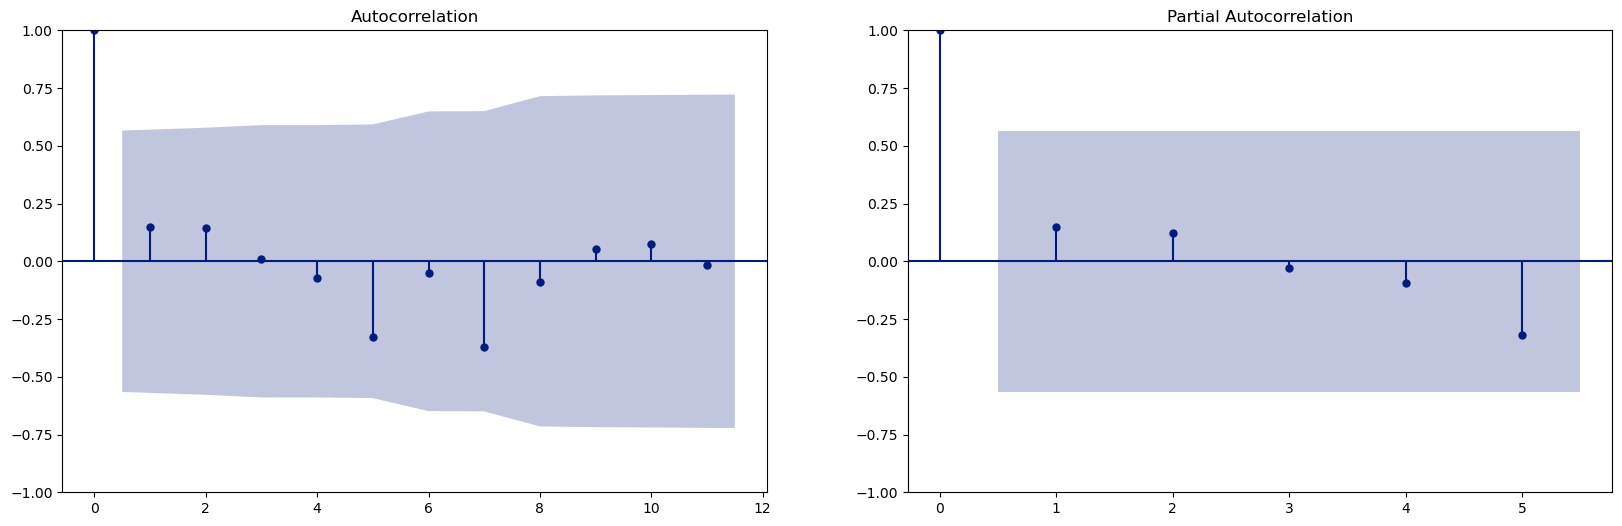

In [24]:
# Autocorrelation - Partial Autocorrelation Plots
def corr_plots(col):
    fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))
    
    plot_acf(col, ax = ax[0]);
    plot_pacf(col, lags = 5, method = 'ywmle', ax = ax[1]);
    return plt.show()


# ACF and PACF on inflation residuals
corr_plots(inf.resid)

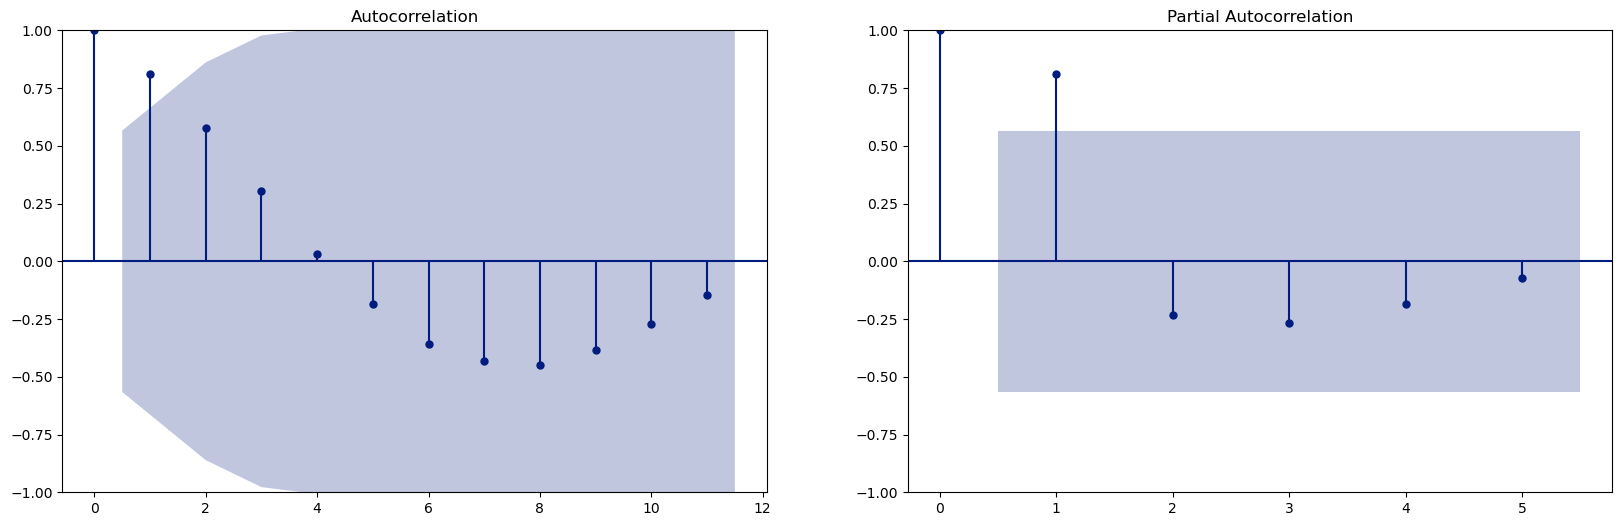

In [25]:
# ACF and PACF on inflation
corr_plots(inf.inflacion)

### 4.2.2 Bank Intervention Fee - TIP

In [26]:
tip = pd.read_excel('1_TIP.xlsx', skiprows = 7)

def tweak_tip(df):
    return (
        df
        # Rename columns
        .rename(columns = {'Fecha (dd/mm/aaaa)' : 'date', 'Tasa de intervención de política monetaria (%)' : 'tip'})
        # Index changes
        .set_index('date')
        .resample('MS').mean()
        .loc[ts_temp.index]
    )


tip = tweak_tip(tip)
tip

,tip
date,
2022-04-01,5.000000
2022-05-01,5.967742
2022-06-01,6.000000
2022-07-01,7.500000
2022-08-01,9.000000
2022-09-01,9.033333
2022-10-01,10.032258
2022-11-01,11.000000
2022-12-01,11.419355


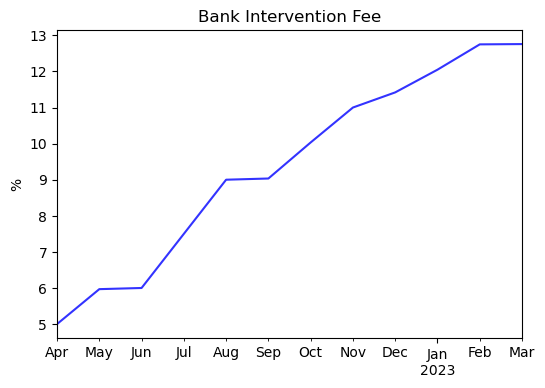

In [27]:
tip.plot(legend = False, color = 'b', alpha = 0.8, figsize = (6, 4))

plt.title('Bank Intervention Fee')
plt.xlabel('')
plt.ylabel('%')

plt.show()

In [28]:
# Extract trend component
x = np.arange(0, len(tip))
tip_lws = lowess(tip.tip, x, frac = 0.4, it = 3)

# Add trend and residuals to TIP dataframe
tip = df_trend(tip, tip_lws, tip.tip)

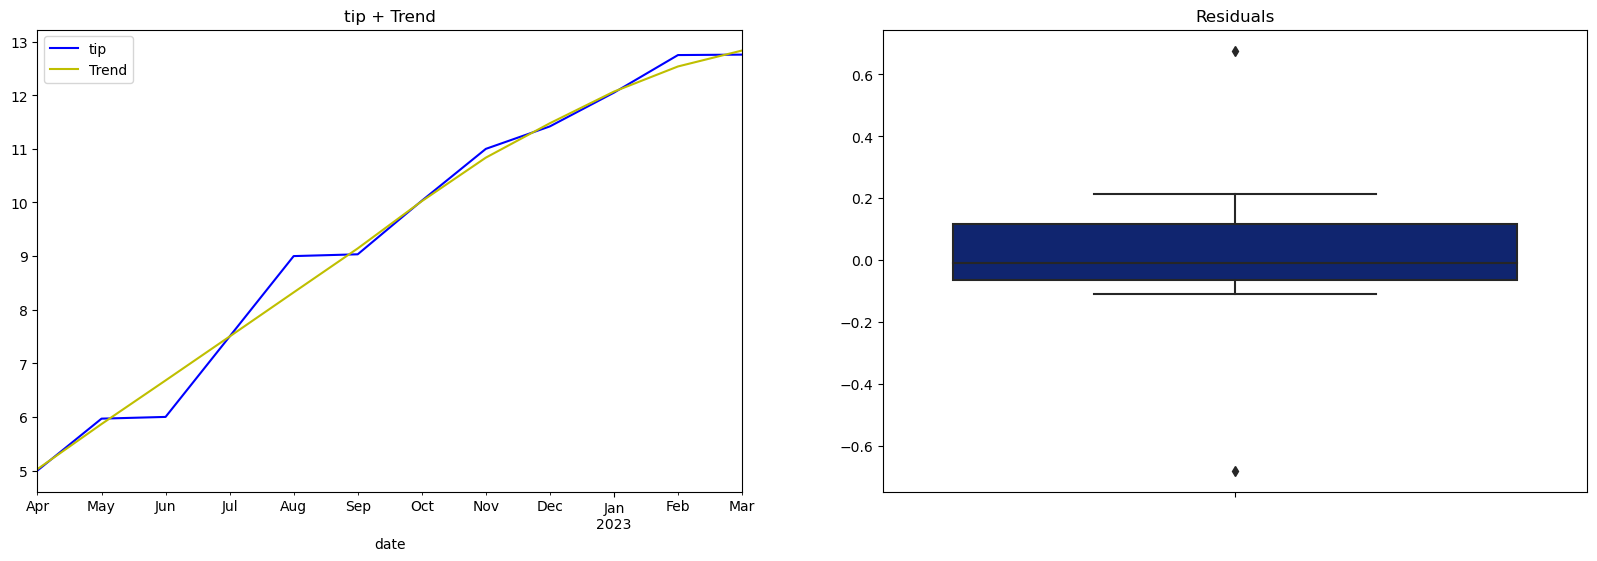

In [29]:
plot_df(tip, 'tip')

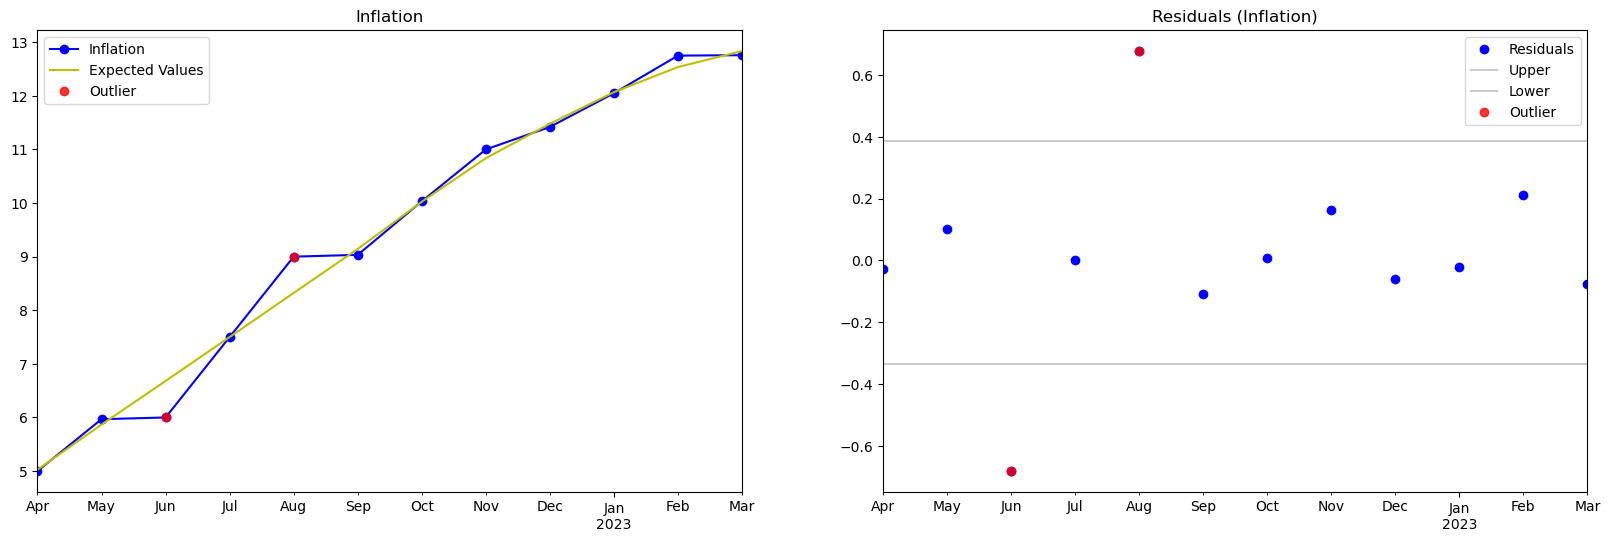

In [30]:
# Add and highlight outliers
tip = outliers(tip)

# Plotting outliers
plot_outliers(tip, 'tip')

In [31]:
# Remove outliers 
tip.loc[tip.is_outlier, 'tip'] = np.nan

# Replacing values thru linear interpolation
tip = tip.interpolate(method = 'linear')

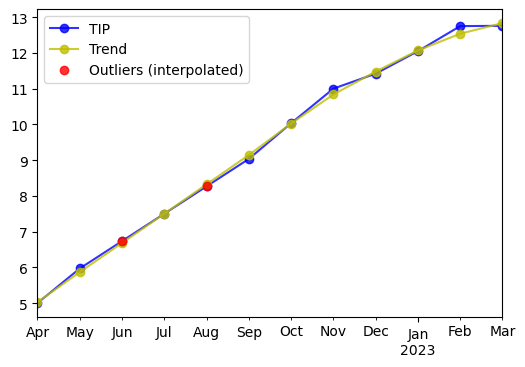

In [32]:
# Plot TIP clean data without outliers
fig, ax = plt.subplots(figsize = (6, 4))
tip.plot(y = 'tip', marker = 'o', color = 'b', alpha = 0.8, ax = ax)
tip.plot(y = 'trend', marker = 'o', color = 'y', alpha = 0.8, ax = ax)
tip.loc[tip.is_outlier].plot(y = 'tip', marker = 'o', linestyle = '', color = 'r', alpha = 0.8, ax = ax)

plt.legend(['TIP', 'Trend', 'Outliers (interpolated)'])
plt.xlabel('')

plt.show()


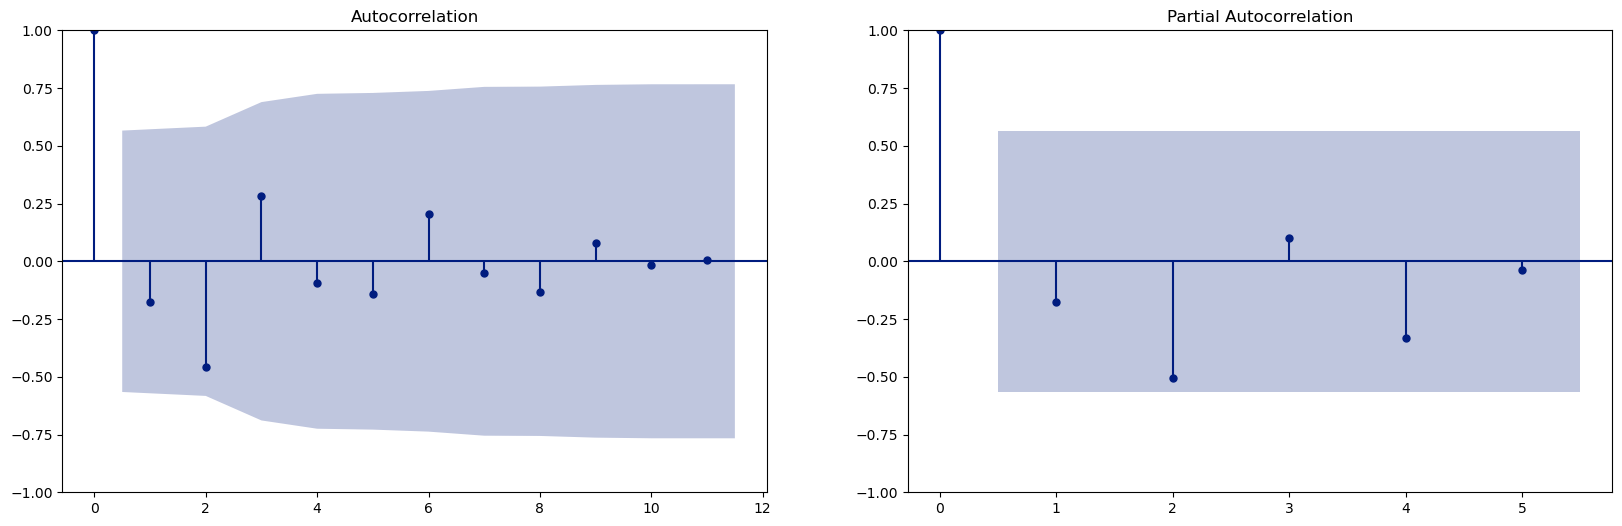

In [33]:
# ACF and PACF on TIP residuals
corr_plots(tip.resid)

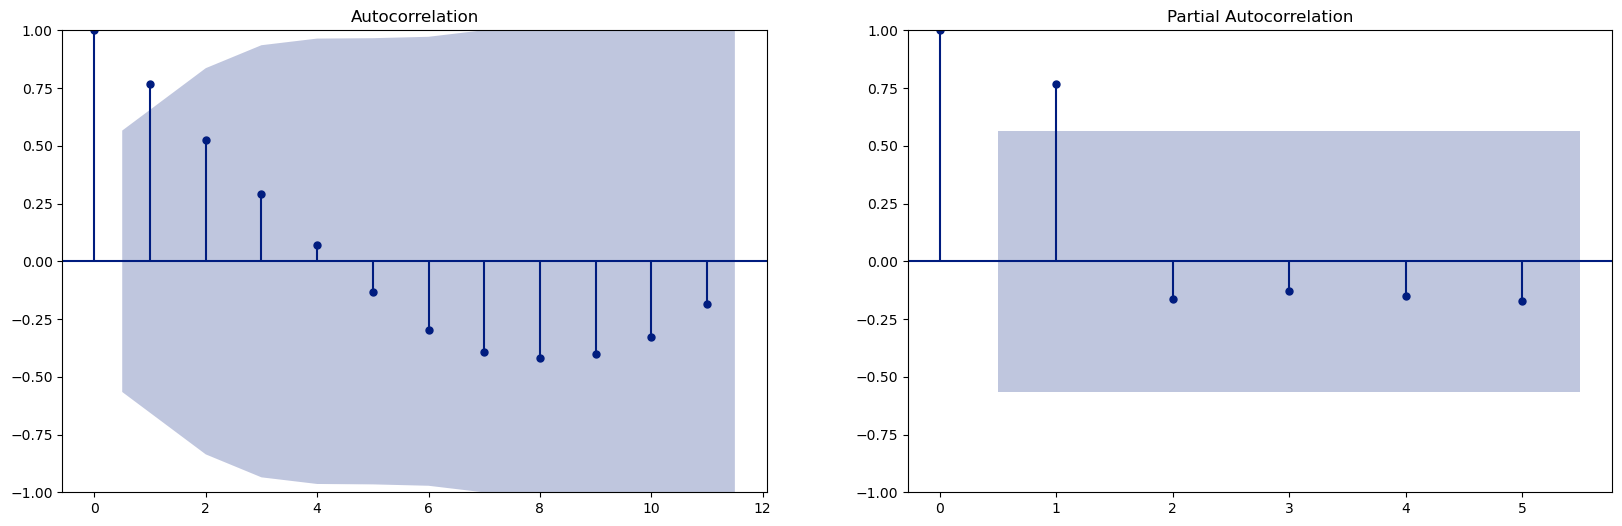

In [34]:
# ACF and PACF on TIP
corr_plots(tip.tip)

### 4.2.3 Market's Representative Exchange-Rate - Colombian Peso vs. USD - TRM

In [35]:
trm = pd.read_excel('1_TRM.xlsx', skiprows = 7)

# Cleaning TRM dataframe
def tweak_trm(df):
    return(
        df
        # Renaming columns
        .rename(columns = {'Año - Mes (aaaa -mm)' : 'date', 'Promedio mensual' : 'trm'})
        # Drop unnecesary columns
        .drop(columns = 'Fin de mes')
        # Index modifications
        .set_index('date')
        .resample('MS').max()
        # Filter
        .loc[ts_temp.index]
    )


trm = tweak_trm(trm)
trm

,trm
date,
2022-04-01,3796.39
2022-05-01,4027.60
2022-06-01,3922.50
2022-07-01,4394.01
2022-08-01,4326.77
2022-09-01,4437.31
2022-10-01,4714.96
2022-11-01,4922.30
2022-12-01,4787.89


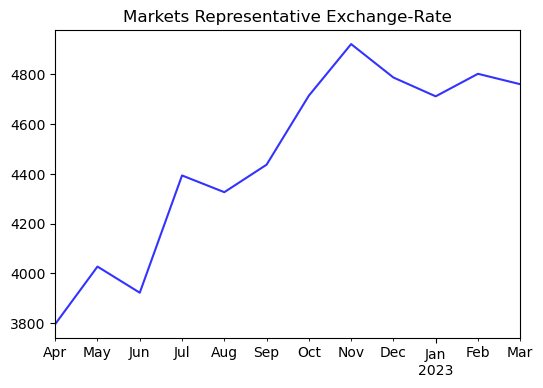

In [36]:
# Plotting TRM data
trm.plot(figsize = (6, 4), color = 'b', alpha = 0.8, legend = False)

plt.xlabel('')
plt.title("Markets Representative Exchange-Rate")

plt.show()

In [37]:
# Extract trend component
x = np.arange(len(trm))
trm_lws = lowess(trm.trm, x, frac = 0.7, it = 3)

# Add trend and residuals to TRM dataframe
trm = df_trend(trm, trm_lws, trm.trm)

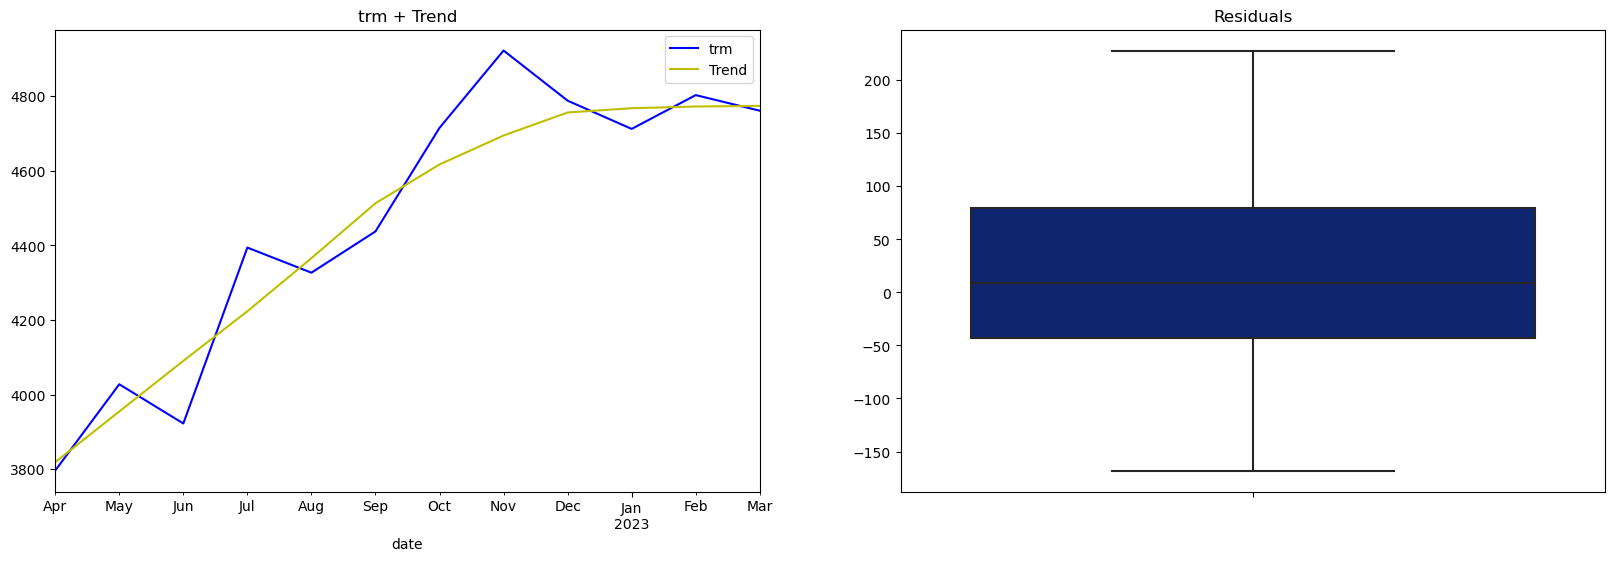

In [38]:
plot_df(trm, 'trm')

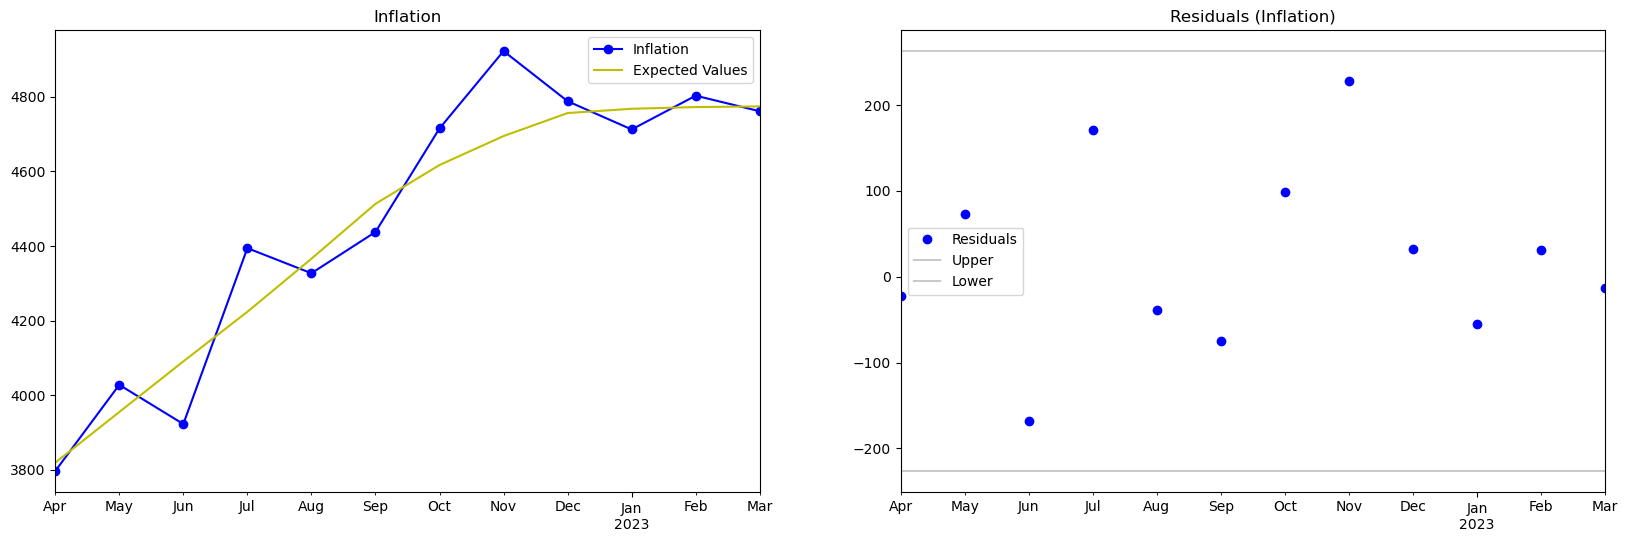

In [39]:
# Add and highlight outliers
trm = outliers(trm)

# Plotting outliers
plot_outliers(trm, 'trm')

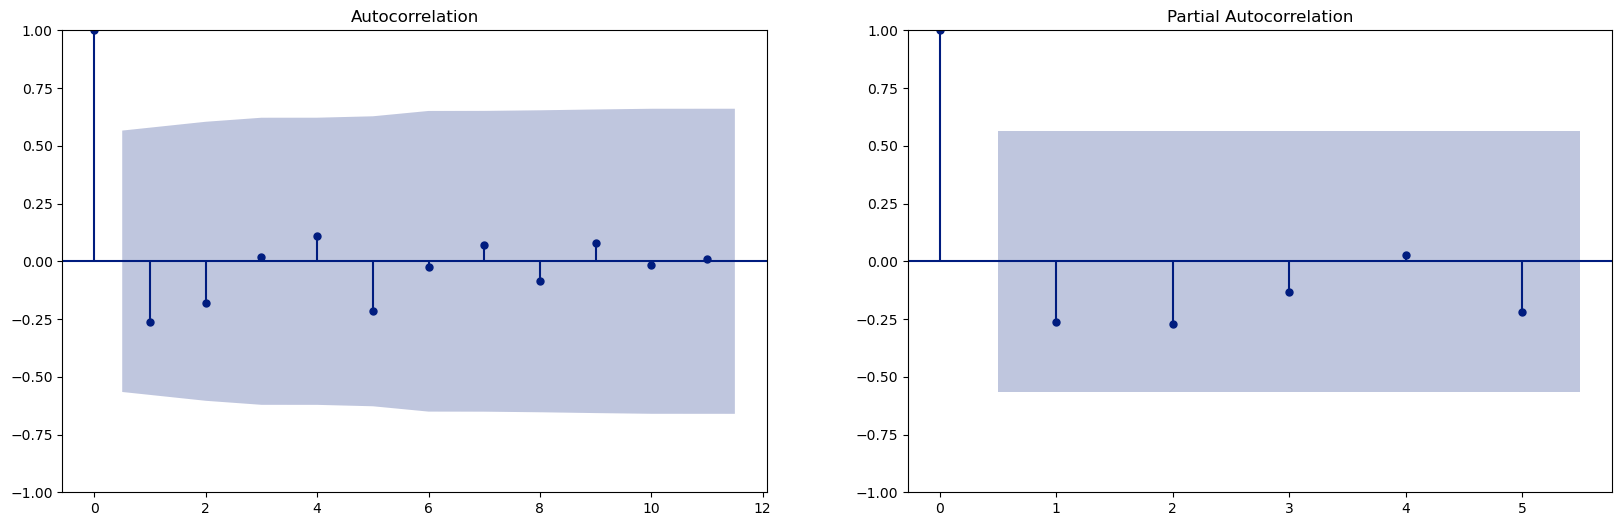

In [40]:
# ACF and PACF on TRM residuals
corr_plots(trm.resid)

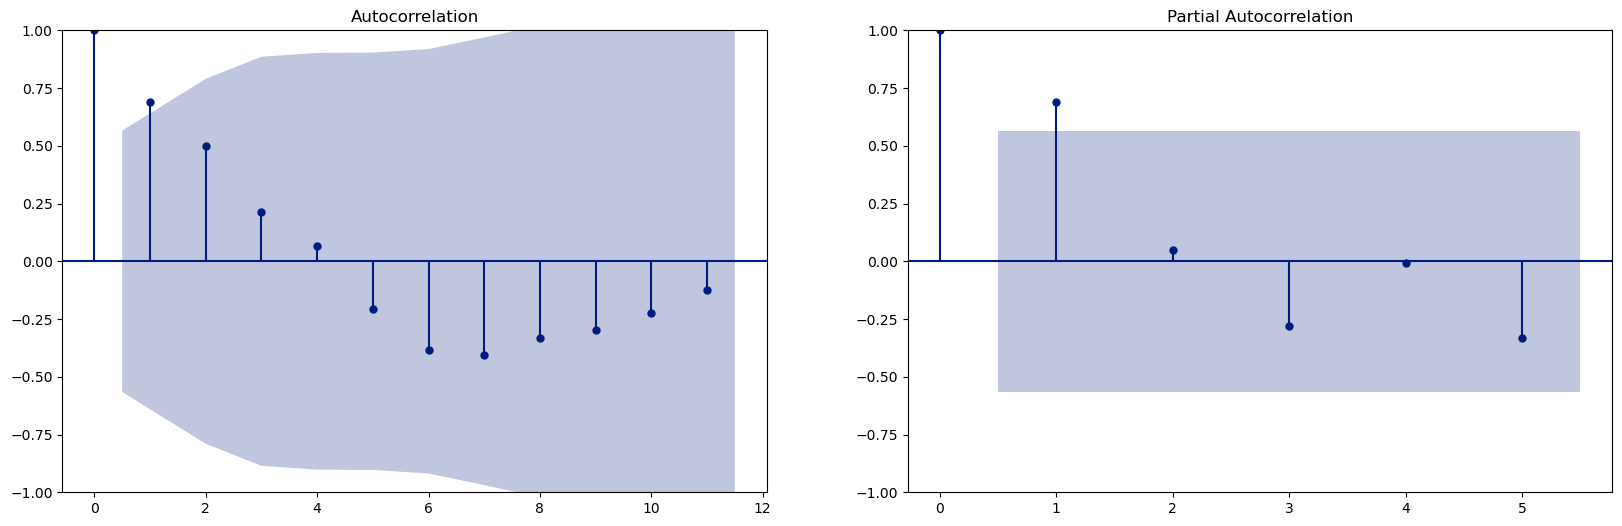

In [41]:
# ACF and PACF on TRM
corr_plots(trm.trm)

<a name = '4.3'><a/>
## 4.3 Feature engineering


- Compute/plot cross-correlation

### 4.3.1 Auto-correlation
Compute/plot total sales auto-correlation: 
- According to PACF on the origial series, the sales lag of 1 could help to forecast

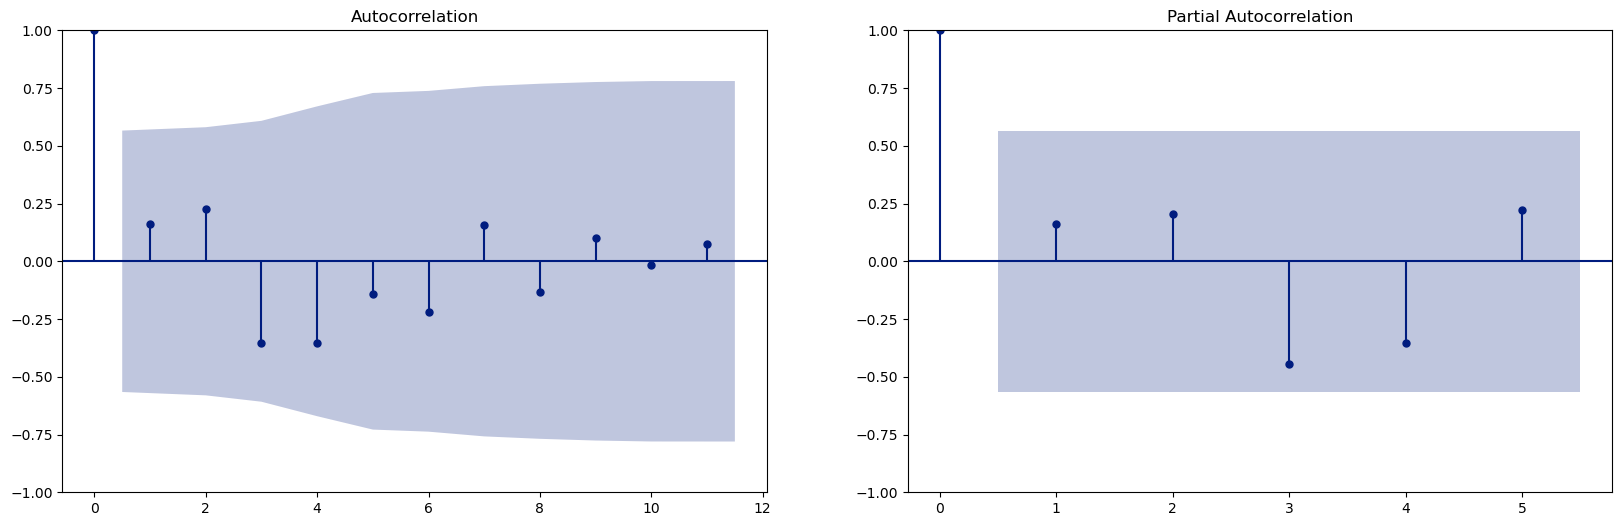

In [42]:
# ACF and PACF on Total Sales residuals
corr_plots(ts_temp.residuals)

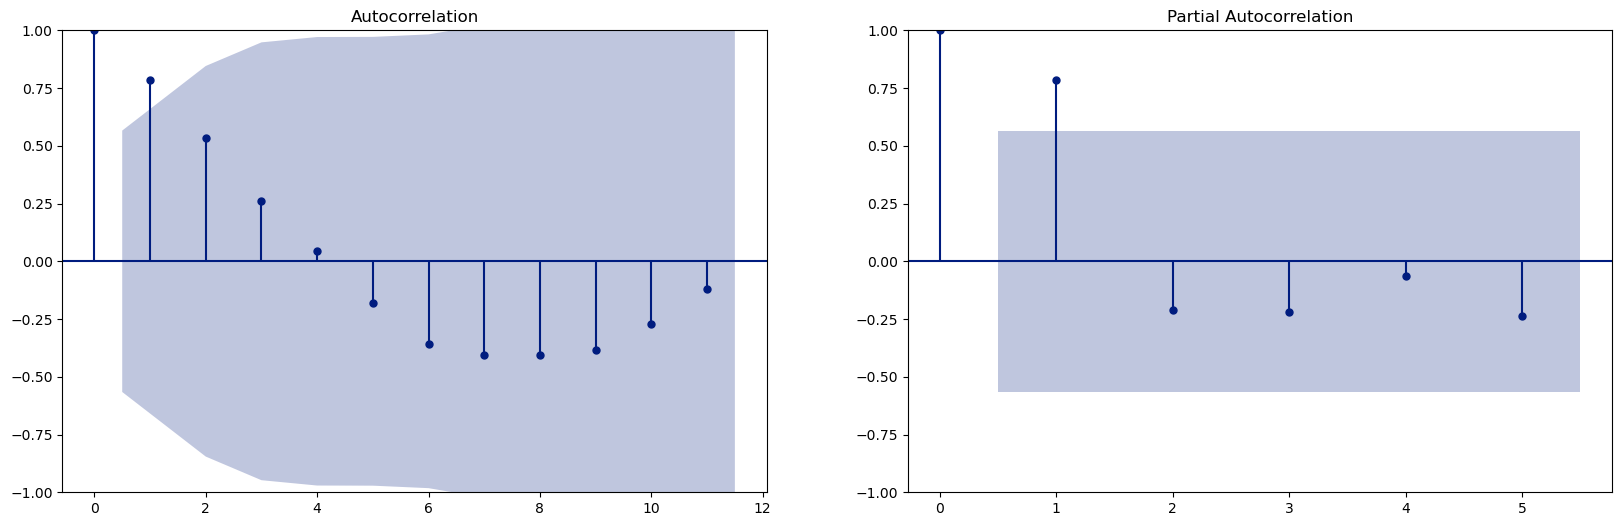

In [43]:
# ACF and PACF on Total Sales
corr_plots(ts_temp.sales)

### 4.3.2 Cross-correlation
**Total sales vs. inflation:** 

- Correlation on inflation lag 2, however the regplot shows less dispertion between the series on lag 3, so it can be usefull in the model too.

**Total sales vs. TRM**

- There's no correlation between the series.

**Total sales vs. TIP**

- Strong correlation on TIP lag 3.

In [44]:
# Function to compute and plot cross-correlation between features
def ccf_(df1, df2, text = 'Sales', text2 = ''):
    
    # Compute cross-correlation
    cross = ccf(df1, df2)
    lags = len(cross)
    ci = 2 / np.sqrt(len(df2))
    
    # Plot results
    fig, ax = plt.subplots(figsize = (6, 4))
    
    ax.stem(np.arange(0, lags), cross)
    ax.fill_between(np.arange(0, lags), ci, y2 = -ci, alpha = 0.2)
    
    ax.set_title(f'Cross-correlation {text} vs. {text2}')
    
    return plt.show()

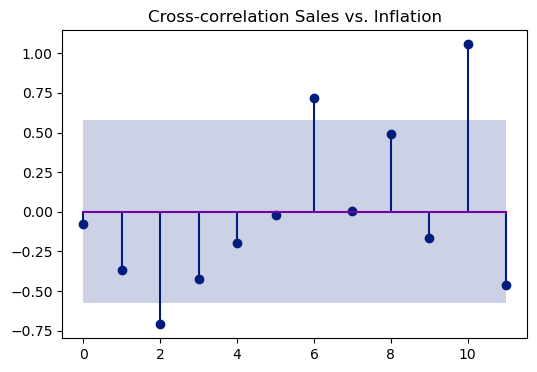

In [45]:
# Sales - inflation cross-correlation
ccf_(ts_temp.residuals, inf.resid, 'Sales', 'Inflation')

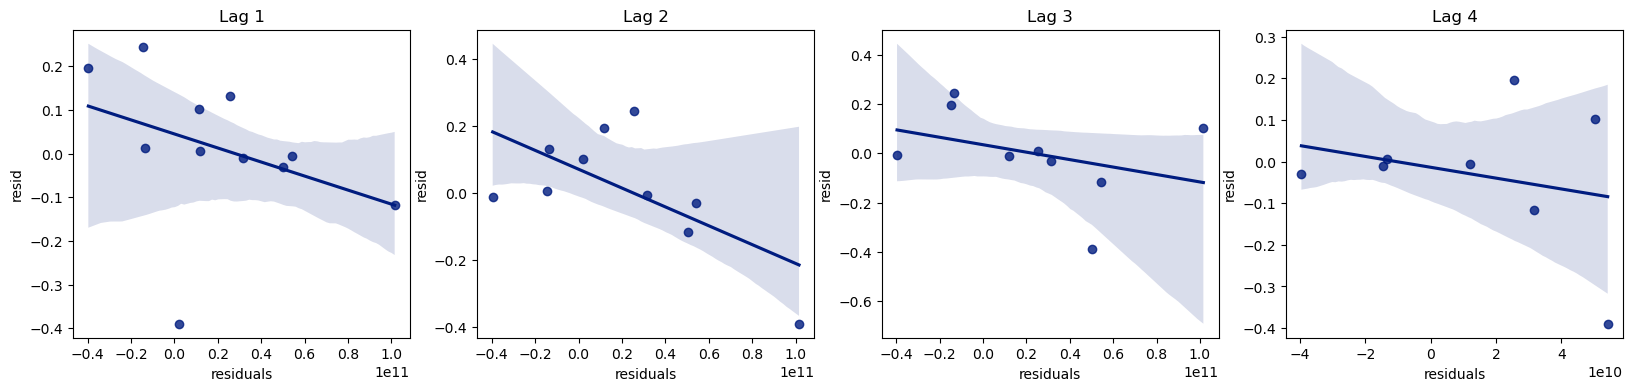

In [46]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 4))

for n in np.arange(0, 4):
    sns.regplot(x = ts_temp.residuals, y = inf.resid.shift(n+1), ax = ax[n])
    ax[n].set_title(f'Lag {n+1}')

plt.show()

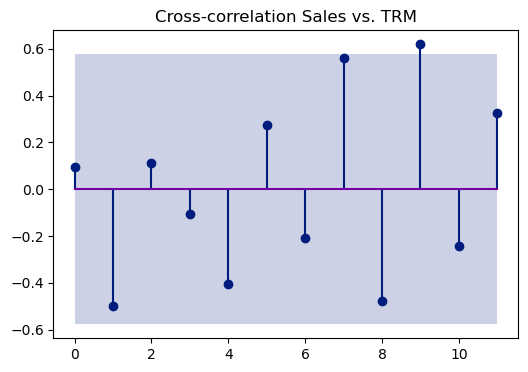

In [47]:
# Sales - TRM cross-correlation
ccf_(ts_temp.residuals, trm.resid, 'Sales', 'TRM')

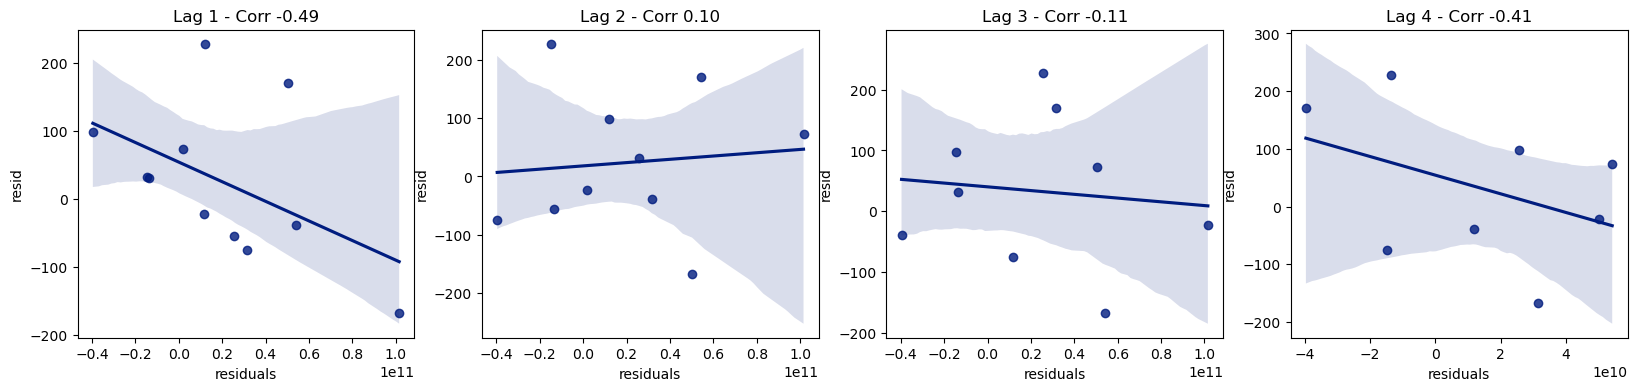

In [48]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 4))

for n in np.arange(0, 4):
    corr_ = ts_temp.residuals.corr(trm.resid.shift(n+1))
    sns.regplot(x = ts_temp.residuals, y = trm.resid.shift(n+1), ax = ax[n])
    ax[n].set_title(f'Lag {n+1} - Corr {corr_:.2f}')

plt.show()

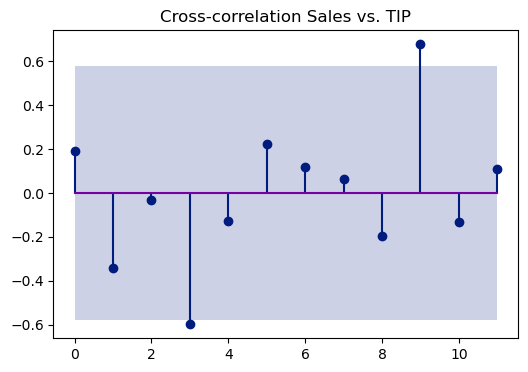

In [49]:
# Sales - TIP cross-correlation
ccf_(ts_temp.residuals, tip.resid, 'Sales', 'TIP')

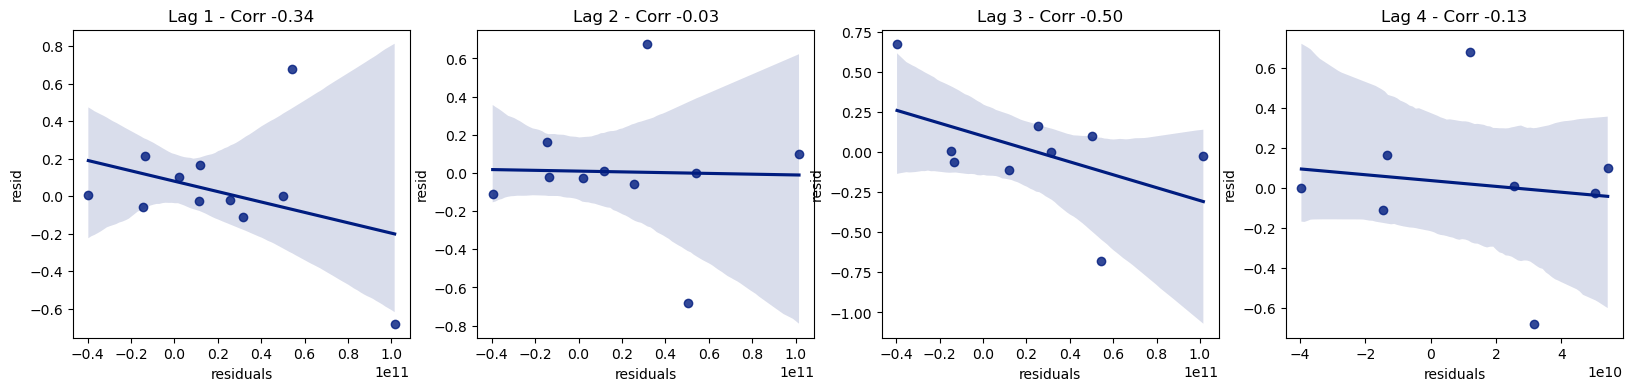

In [50]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 4))

for n in np.arange(0, 4):
    corr_ = ts_temp.residuals.corr(tip.resid.shift(n+1))
    sns.regplot(x = ts_temp.residuals, y = tip.resid.shift(n+1), ax = ax[n])
    ax[n].set_title(f'Lag {n+1} - Corr {corr_:.2f}')

plt.show()


### 4.3.3 Joining dataframes

In [51]:
# Join inflation, TRM and TIP to sales data
def sales_join(df):
    
    # Rename column names
    inf_ = inf.copy().rename(columns = lambda col: f'inf_{col}')
    tip_ = tip.copy().rename(columns = lambda col: f'tip_{col}')

    return (
        df
        .join(inf_)
        .join(tip_)
        .drop(columns = [
            'inf_trend', 'inf_resid', 'inf_upper', 'inf_lower', 'inf_is_outlier',
            'tip_trend', 'tip_resid', 'tip_upper', 'tip_lower', 'tip_is_outlier',
        ])
    )


model = sales_join(total_sales)
model

,sales,inf_inflacion,tip_tip
date,,,
2022-04-01,16746203696564,9.23,5.000000
2022-05-01,17067204812923,9.45,5.967742
2022-06-01,16884631245810,9.67,6.733871
2022-07-01,16664159268504,10.21,7.500000
2022-08-01,16736785138320,10.84,8.266667
2022-09-01,16488010680770,11.44,9.033333
2022-10-01,15829105124719,12.22,10.032258
2022-11-01,15678422290057,12.53,11.000000
2022-12-01,15466780514439,13.12,11.419355


<a name = '5'><a/>
# 5. Lasso Regression

<a name = '5.1'><a/>
## 5.1 Pipeline
Lasso model will receive the following features:

**Total sales (original series):**
- Lag 1 according to PACF,
- Lag 3 and window mean of 3 due to seasonaly of the time series.

**Inflation - TIP series:**
- Lag 1 according to PACF,
- Lag 3 strong correlacion between TIP an sales, less dispertion on this lag in inflation series,
- Window (mean - stantard deviation) of 3 due to the size of the maximum lag on each series.

**Seasonal features:**
- Computed from Fourier series of 1, size of 3 (due to size of each season).

**Trend features:**
- Tree lineal features to capture trend and his changepoints.

In [52]:
# Lag - window Features
inf_sales_fts = WindowSummarizer(
    target_cols = ["sales", "inf_inflacion"],
    lag_feature = {
        'lag' : [1, 3],
        'mean' : [[1, 3]],
    },
    truncate = 'bfill'
)

tip_fts = WindowSummarizer(
    target_cols = ["tip_tip"],
    lag_feature = {
        'lag' : [1, 3],
        'mean' : [[1, 3]],
        'std' : [[1, 3]],
    },
    truncate = 'bfill'
)

# Seasonal feature
ssl_ft = FourierFeatures(
    sp_list = [3],
    fourier_terms_list = [1],
    freq = 'M',
    keep_original_columns = False
)

# Trend features
change_points = ['2022-04-01', '2022-07-01', '2022-08-01']

trend_pipe = Pipeline([
    ('Date', TimeSince(start = change_points, positive_only = True)),
    ('Polynomial', PolynomialFeatures(degree = 1, include_bias = False))
])

In [53]:
# Create Pipeline
pipeline = make_union(
    trend_pipe,
    ssl_ft,
    inf_sales_fts,
    tip_fts,
)

# Scaling features / drop unnecessary columns
pipeline = make_pipeline(
    pipeline, 
    MinMaxScaler(), 
    DropFeatures(features_to_drop = ['sales', 'inf_inflacion', 'tip_tip'])
)

pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('Date',
                                                                  TimeSince(positive_only=True, start=['2022-04-01', '2022-07-01', '2022-08-01'])),
                                                                 ('Polynomial',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('fourierfeatures',
                                                 FourierFeatures(fourier_terms_list=[1], freq='M', sp_list=[3])),
                                                ('windowsummarizer-1',
                                                 Wind...eature={'lag': [1, 3], 'mean': [[1, 3]]},
                 target_cols=['sales', 'inf_inflacion'], truncate='bfill')),
                                                ('windowsummarizer-2',
                                                 WindowSummarizer(lag_feature={'lag': [1, 3], 'mean': [[1, 3]], 'std': [[1, 3]]},
                 target_cols=['tip_tip'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler()),
                ('dropfeatures',
                 DropFeatures(features_to_drop=['sales', 'inf_inflacion',
                                                'tip_tip']))])

In [54]:
pipeline.fit_transform(model)

,time_since_2022-04-01 00:00:00,time_since_2022-07-01 00:00:00,time_since_2022-08-01 00:00:00,sin_3_1,cos_3_1,sales_lag_1,sales_lag_3,sales_mean_1_3,inf_inflacion_lag_1,inf_inflacion_lag_3,inf_inflacion_mean_1_3,tip_tip_lag_1,tip_tip_lag_3,tip_tip_mean_1_3,tip_tip_std_1_3
date,,,,,,,,,,,,,,,
2022-04-01,0.000000,0.000,0.000000,5.000000e-01,1.000000e+00,0.865705,0.799427,0.976380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068136
2022-05-01,0.090909,0.000,0.000000,1.000000e+00,1.332268e-15,0.865705,0.799427,0.976380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068136
2022-06-01,0.181818,0.000,0.000000,2.220446e-16,8.881784e-16,1.000000,0.799427,0.976380,0.054321,0.000000,0.000000,0.124870,0.000000,0.000000,0.068136
2022-07-01,0.272727,0.000,0.000000,5.000000e-01,1.000000e+00,0.923618,0.799427,1.000000,0.108642,0.000000,0.037479,0.223725,0.000000,0.085623,0.748764
2022-08-01,0.363636,0.125,0.000000,1.000000e+00,1.720846e-15,0.831381,1.000000,0.986001,0.241975,0.056555,0.120954,0.322581,0.150754,0.209080,0.523269
2022-09-01,0.454545,0.250,0.142857,0.000000e+00,1.276756e-15,0.861765,0.885922,0.929620,0.397531,0.113111,0.239353,0.421505,0.270101,0.322607,0.523859
2022-10-01,0.545455,0.375,0.285714,5.000000e-01,1.000000e+00,0.757687,0.748163,0.861944,0.545679,0.251928,0.390119,0.520430,0.389447,0.436161,0.524448
2022-11-01,0.636364,0.500,0.428571,1.000000e+00,1.831868e-15,0.482025,0.793542,0.719456,0.738272,0.413882,0.561329,0.649324,0.508878,0.561211,0.784865
2022-12-01,0.727273,0.625,0.571429,6.106227e-16,1.110223e-16,0.418985,0.638100,0.538865,0.814815,0.568123,0.705281,0.774194,0.628308,0.696190,1.000000


<a name = '5.2'><a/>
## 5.2 Regression Model

In [55]:
# Reset pipeline
pipeline = clone(pipeline)

# Train - test split
targets = ['sales', 'inf_inflacion', 'tip_tip']
train = model.loc[model.index < '2023-01-01'].copy()
test = model.loc[model.index >= '2023-01-01'].copy()

# Fitting pipeline
x_train = pipeline.fit_transform(train[targets])
y_train = train[['sales', 'inf_inflacion', 'tip_tip']]

In [56]:
ridge = MultiOutputRegressor(Ridge(alpha = 0.165, max_iter = 1000, random_state = 0))

ridge.fit(x_train, y_train)

MultiOutputRegressor(estimator=Ridge(alpha=0.165, max_iter=1000,
                                     random_state=0))

### 5.2.1 Recursive Forecasting (until march 2023)

In [57]:
#Recursive forcasting until march 2023

# Setting parameters to create forecasting horizon
start_date = pd.Timestamp('2023-01-01')
end_date = start_date + pd.offsets.MonthBegin(2)

forecast_horizon = pd.date_range(start = start_date, end = end_date, freq = '1MS')

# Dynamic prediction dataframe to append all the forecasts
df_predict = train[targets].loc[start_date - pd.offsets.MonthBegin(4):]
df_predict = pd.concat([df_predict, pd.DataFrame(index = forecast_horizon)])

# Recursive forrecasting loop
for date in forecast_horizon:
    x_test = pipeline.transform(df_predict.loc[:date])
    forecast_point = x_test.loc[[date]]
   
    pred = ridge.predict(forecast_point)
    df_predict.loc[[date]] = pred

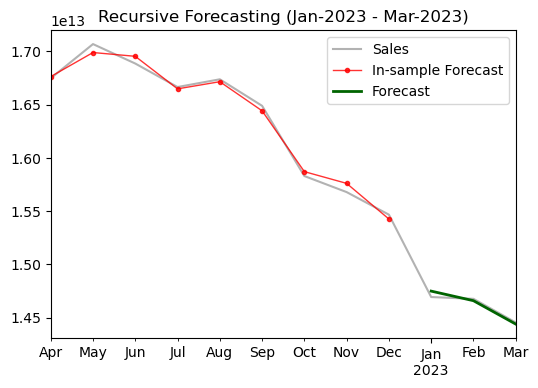

In [58]:
# Include train predictions in dataframe
train['predict'] = ridge.predict(pipeline.transform(train[targets]))[:,0]

# Plotting sales and forecast (in-sample / recursive)
fig, ax = plt.subplots(figsize = (6, 4))

model.plot(y = 'sales', lw = 1.5, color = 'gray', alpha = 0.6, ax = ax)
train.plot(y = 'predict', lw = 1, color = 'r', alpha = 0.8, marker = '.', ax = ax,)
df_predict.loc['2023-01-01':].plot(y = 'sales', lw = 1, marker = '.', color = 'darkgreen', ax = ax)

plt.title('Recursive Forecasting (Jan-2023 - Mar-2023)')
plt.xlabel('')
plt.legend(['Sales', 'In-sample Forecast', 'Forecast'])

plt.show()

### 5.2.2 Performance - RMES

#### Naive Forecast - basic level performance

In [59]:
print(f"Train RMSE: {mse(model.loc[model.index < '2023-01-01'].sales[1:], model.loc[model.index < '2023-01-01'].sales.shift(1).dropna(), squared = False):,.2f}")
print(f"Test RMSE: {mse(model.loc[model.index >= '2023-01-01'].sales[1:], model.loc[model.index >= '2023-01-01'].sales.shift(1).dropna(), squared = False):,.2f}")

Train RMSE: 306,960,920,604.83
Test RMSE: 157,097,487,945.07


#### Model performance

In [60]:
print(f"Model train RMSE: {mse(y_train, ridge.predict(x_train), squared = False):,.2f}")
print(f"Model test RMSE: {mse(test.sales, df_predict.loc['2023-01-01':, 'sales'], squared = False):,.2f}")

Model train RMSE: 17,285,274,821.24
Model test RMSE: 34,796,035,212.65


### 5.2.3 Recursive Forecasting (until january 2025)

In [61]:
# Expand the forecast horizon to january 2025
start = pd.Timestamp('2023-01-01')
end = start + pd.offsets.MonthBegin(24)

forecast_horizon = pd.date_range(start = start, end = end, freq = '1MS')
df_predict = pd.concat([train[targets].loc[start - pd.offsets.MonthBegin(4):], pd.DataFrame(index = forecast_horizon)])

for date in forecast_horizon:
    x_test = pipeline.transform(df_predict.loc[ : date])
    forecast_point = x_test.loc[[date]]

    pred = ridge.predict(forecast_point)
    df_predict.loc[[date]] = pred

In [62]:
# Include train predictions in dataframe
train['predict'] = ridge.predict(pipeline.transform(train[targets]))[:,0]

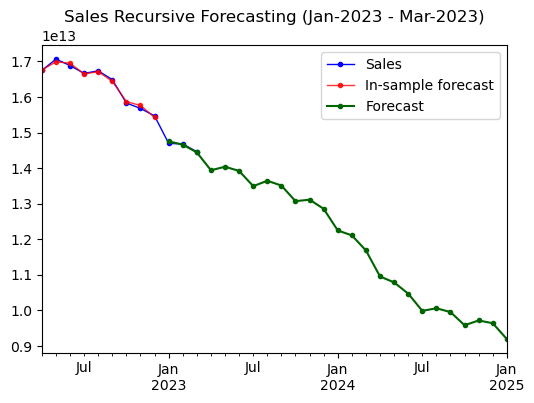

In [63]:
# Plotting forecast until Jan-2025
fig, ax = plt.subplots(figsize = (6, 4))

model.plot(y = 'sales', lw = 1, color = 'blue', marker = '.', ax = ax)
train.plot(y = 'predict', lw = 1, color = 'r', alpha = 0.8, marker = '.', ax = ax,)
df_predict.loc['2023-01-01':].plot(y = 'sales', lw = 1.5, 
                                   color = 'darkgreen', marker = '.',
                                   ax = ax)

plt.title('Sales Recursive Forecasting (Jan-2023 - Mar-2023)')
plt.xlabel('')
plt.legend(['Sales', 'In-sample forecast', 'Forecast'])

plt.show()


<a name = '6'><a/>
# 6. Annual Growth
Compute the annual growth on each month after forecasting

In [64]:
# Create growth dataframe to store data sales and predictions
growth = (pd.concat([
    total_sales.sales,
    df_predict.loc['2023-04-01':].sales
])
 .to_frame()
)

# Function to comtute annual growth and annual percent growth
def compute_growth(df):
    g = df.sales.sub(df.sales.shift(12)).fillna(df.sales.sub(df.sales))
    return(
        df
        .assign(
            growth = g,
            growth_perc = g.div(df.sales.shift(12).fillna(df.sales)),
        )
          )


growth = compute_growth(growth)
growth.sample(10)

,sales,growth,growth_perc
2024-04-01,1.094667e+13,-2.989668e+12,-0.214523
2024-09-01,9.944544e+12,-3.561566e+12,-0.263700
2023-08-01,1.364065e+13,-3.096135e+12,-0.184990
2024-10-01,9.573452e+12,-3.493287e+12,-0.267342
2023-01-01,1.469378e+13,0.000000e+00,0.000000
2024-06-01,1.046318e+13,-3.453750e+12,-0.248169
2024-12-01,9.629805e+12,-3.221543e+12,-0.250677
2022-05-01,1.706720e+13,0.000000e+00,0.000000
2022-08-01,1.673679e+13,0.000000e+00,0.000000
2022-09-01,1.648801e+13,0.000000e+00,0.000000


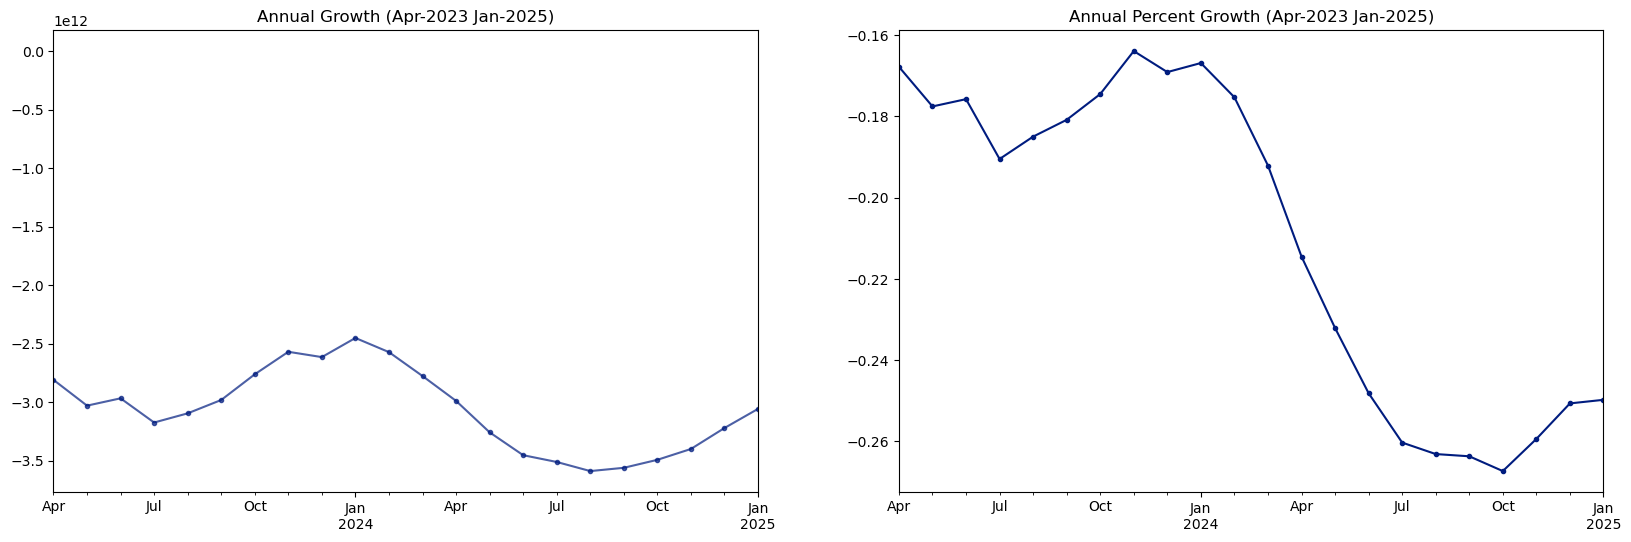

In [65]:
fig, ax = plt.subplots(ncols = 2, figsize = (20, 6))

growth.growth.loc['2023-04-01':].plot(legend = False, marker = '.', alpha = 0.7, ax = ax[0])
growth.growth_perc.loc['2023-04-01':].plot(marker = '.', legend = False, ax = ax[1])

ax[0].fill_between(growth.index, 0, growth.growth, where = growth.growth < 0, color = 'r')

ax[0].set_title('Annual Growth (Apr-2023 Jan-2025)')
ax[1].set_title('Annual Percent Growth (Apr-2023 Jan-2025)')

plt.show()